<a href="https://colab.research.google.com/github/SnuggleAspect/Complete-Python-3-Bootcamp/blob/master/PhysicalFitness_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install garminconnect matplotlib pandas seaborn plotly polars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 1.8 MB/s eta 0:00:00


In [2]:
from garminconnect import Garmin
import json
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from google.colab import files

# Function to authenticate with Garmin Connect
def garmin_connect(email, password):
    try:
        # Initialize API
        client = Garmin(email, password)
        # Login
        client.login()
        return client
    except Exception as e:
        print(f"Error during Garmin Connect authentication: {e}")
        return None

# For security, you'll enter credentials when you run the notebook
import getpass
email = input("Enter your Garmin Connect email: ")
password = getpass.getpass("Enter your Garmin Connect password: ")

# Connect to Garmin
client = garmin_connect(email, password)

Enter your Garmin Connect email: patrick.anb@gmail.com
Enter your Garmin Connect password: ··········


In [4]:
def get_activities(client, activity_type='cycling', start_date=None, end_date=None):
    """
    Fetch activities from Garmin Connect

    Parameters:
    - client: Authenticated Garmin client
    - activity_type: Type of activity to fetch ('cycling', 'running', etc.)
    - start_date: Start date (datetime object)
    - end_date: End date (datetime object)

    Returns:
    - Pandas DataFrame with activity data
    """
    if not start_date:
        start_date = datetime.now() - timedelta(days=30)
    if not end_date:
        end_date = datetime.now()

    # Format dates as required by Garmin API
    start = start_date.strftime("%Y-%m-%d")
    end = end_date.strftime("%Y-%m-%d")

    try:
        # Get activities
        activities = client.get_activities_by_date(start, end)

        # Filter for cycling activities
        if activity_type:
            activities = [a for a in activities if a['activityType']['typeKey'].lower() == activity_type.lower()]

        # Convert to DataFrame
        if activities:
            df = pd.json_normalize(activities)
            return df
        else:
            print(f"No {activity_type} activities found in the specified date range.")
            return pd.DataFrame()
    except Exception as e:
        print(f"Error fetching activities: {e}")
        return pd.DataFrame()

def get_sleep_data(client, start_date=None, end_date=None):
    """
    Fetch sleep data from Garmin Connect

    Parameters:
    - client: Authenticated Garmin client
    - start_date: Start date (datetime object)
    - end_date: End date (datetime object)

    Returns:
    - List of sleep data dictionaries
    """
    if not start_date:
        start_date = datetime.now() - timedelta(days=30)
    if not end_date:
        end_date = datetime.now()

    sleep_data = []
    current_date = start_date

    try:
        while current_date <= end_date:
            date_str = current_date.strftime("%Y-%m-%d")
            daily_sleep = client.get_sleep_data(date_str)

            if daily_sleep:
                sleep_data.append(daily_sleep)

            current_date += timedelta(days=1)

        # Process sleep data into DataFrame
        processed_data = []
        for day in sleep_data:
            if 'sleepSegments' in day and day['sleepSegments']:
                sleep_date = day.get('calendarDate', 'Unknown')
                total_sleep = day.get('deepSleepSeconds', 0) + day.get('lightSleepSeconds', 0) + day.get('remSleepSeconds', 0)
                total_sleep_hours = total_sleep / 3600
                deep_sleep_hours = day.get('deepSleepSeconds', 0) / 3600
                light_sleep_hours = day.get('lightSleepSeconds', 0) / 3600
                rem_sleep_hours = day.get('remSleepSeconds', 0) / 3600

                processed_data.append({
                    'Date': sleep_date,
                    'Total Sleep (hours)': total_sleep_hours,
                    'Deep Sleep (hours)': deep_sleep_hours,
                    'Light Sleep (hours)': light_sleep_hours,
                    'REM Sleep (hours)': rem_sleep_hours,
                    'Sleep Score': day.get('sleepScoreValue', None)
                })

        return pd.DataFrame(processed_data)
    except Exception as e:
        print(f"Error fetching sleep data: {e}")
        return pd.DataFrame()

In [6]:
def visualize_biking_data(biking_df):
    """
    Create visualizations for biking data

    Parameters:
    - biking_df: Pandas DataFrame with biking data
    """
    if biking_df.empty:
        print("No biking data available to visualize.")
        return

    # Prepare data
    biking_df['startTimeLocal'] = pd.to_datetime(biking_df['startTimeLocal'])
    biking_df['Date'] = biking_df['startTimeLocal'].dt.date

    # Clean distance data (convert to km)
    if 'distance' in biking_df.columns:
        biking_df['distance_km'] = biking_df['distance'] / 1000

    # 1. Distance over time
    plt.figure(figsize=(12, 6))
    plt.plot(biking_df['Date'], biking_df['distance_km'], marker='o', linestyle='-')
    plt.title('Biking Distance Over Time')
    plt.xlabel('Date')
    plt.ylabel('Distance (km)')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 2. Speed and Heart Rate Analysis
    if 'averageSpeed' in biking_df.columns and 'averageHR' in biking_df.columns:
        # Convert speed from m/s to km/h
        biking_df['average_speed_kmh'] = biking_df['averageSpeed'] * 3.6

        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Plot speed
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Average Speed (km/h)', color='tab:blue')
        ax1.plot(biking_df['Date'], biking_df['average_speed_kmh'], color='tab:blue', marker='o')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        # Create second y-axis for heart rate
        ax2 = ax1.twinx()
        ax2.set_ylabel('Average Heart Rate (bpm)', color='tab:red')
        ax2.plot(biking_df['Date'], biking_df['averageHR'], color='tab:red', marker='s')
        ax2.tick_params(axis='y', labelcolor='tab:red')

        plt.title('Average Speed vs Heart Rate Over Time')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # 3. Interactive plot with Plotly
    if 'distance_km' in biking_df.columns and 'duration' in biking_df.columns:
        # Convert duration from seconds to minutes
        biking_df['duration_minutes'] = biking_df['duration'] / 60

        fig = px.scatter(
            biking_df,
            x='duration_minutes',
            y='distance_km',
            size='calories' if 'calories' in biking_df.columns else None,
            color='averageHR' if 'averageHR' in biking_df.columns else None,
            hover_name='Date',
            title='Biking Distance vs Duration',
            labels={
                'distance_km': 'Distance (km)',
                'duration_minutes': 'Duration (minutes)',
                'calories': 'Calories Burned',
                'averageHR': 'Average Heart Rate (bpm)'
            }
        )

        fig.show()

def visualize_sleep_data(sleep_df):
    """
    Create visualizations for sleep data

    Parameters:
    - sleep_df: Pandas DataFrame with sleep data
    """
    if sleep_df.empty:
        print("No sleep data available to visualize.")
        return

    # Convert date to datetime
    sleep_df['Date'] = pd.to_datetime(sleep_df['Date'])
    sleep_df = sleep_df.sort_values('Date')

    # 1. Sleep duration stacked bar chart
    plt.figure(figsize=(14, 7))

    # Create stacked bar chart
    width = 0.8
    bottom_vals = np.zeros(len(sleep_df))

    for col, color in zip(['Deep Sleep (hours)', 'REM Sleep (hours)', 'Light Sleep (hours)'],
                         ['#3A0CA3', '#F72585', '#4CC9F0']):
        if col in sleep_df.columns:
            plt.bar(sleep_df['Date'], sleep_df[col], width, bottom=bottom_vals, label=col, color=color)
            bottom_vals += sleep_df[col].values

    plt.title('Sleep Duration and Quality Over Time')
    plt.xlabel('Date')
    plt.ylabel('Hours')
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 2. Sleep score over time
    if 'Sleep Score' in sleep_df.columns:
        plt.figure(figsize=(14, 6))
        plt.plot(sleep_df['Date'], sleep_df['Sleep Score'], marker='o', linestyle='-', color='#FF5733')
        plt.title('Sleep Score Over Time')
        plt.xlabel('Date')
        plt.ylabel('Sleep Score')
        plt.ylim(0, 105)  # Assuming sleep score is out of 100
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # 3. Interactive sleep visualization with Plotly
    fig = go.Figure()

    # Add traces for each sleep type
    if 'Deep Sleep (hours)' in sleep_df.columns:
        fig.add_trace(go.Scatter(
            x=sleep_df['Date'],
            y=sleep_df['Deep Sleep (hours)'],
            mode='lines+markers',
            name='Deep Sleep',
            line=dict(color='#3A0CA3', width=2)
        ))

    if 'REM Sleep (hours)' in sleep_df.columns:
        fig.add_trace(go.Scatter(
            x=sleep_df['Date'],
            y=sleep_df['REM Sleep (hours)'],
            mode='lines+markers',
            name='REM Sleep',
            line=dict(color='#F72585', width=2)
        ))

    if 'Light Sleep (hours)' in sleep_df.columns:
        fig.add_trace(go.Scatter(
            x=sleep_df['Date'],
            y=sleep_df['Light Sleep (hours)'],
            mode='lines+markers',
            name='Light Sleep',
            line=dict(color='#4CC9F0', width=2)
        ))

    # Update layout
    fig.update_layout(
        title='Sleep Patterns Over Time',
        xaxis_title='Date',
        yaxis_title='Hours',
        legend_title='Sleep Type',
        hovermode='x unified'
    )

    fig.show()

In [8]:
def analyze_biking_sleep_correlation(biking_df, sleep_df):
    """
    Analyze correlation between biking activity and sleep quality

    Parameters:
    - biking_df: DataFrame with biking data
    - sleep_df: DataFrame with sleep data
    """
    if biking_df.empty or sleep_df.empty:
        print("Insufficient data for correlation analysis.")
        return

    # Prepare biking data
    biking_df['startTimeLocal'] = pd.to_datetime(biking_df['startTimeLocal'])
    biking_df['Date'] = biking_df['startTimeLocal'].dt.date
    biking_df['distance_km'] = biking_df['distance'] / 1000 if 'distance' in biking_df.columns else 0

    # Prepare sleep data
    sleep_df['Date'] = pd.to_datetime(sleep_df['Date']).dt.date

    # Aggregate biking data by date (in case of multiple rides per day)
    biking_agg = biking_df.groupby('Date').agg({
        'distance_km': 'sum',
        'duration': 'sum',
        'calories': 'sum' if 'calories' in biking_df.columns else lambda x: 0
    }).reset_index()

    # Merge datasets on date
    merged_df = pd.merge(biking_agg, sleep_df, on='Date', how='inner')

    if len(merged_df) < 2:
        print("Not enough matching dates between biking and sleep data for analysis.")
        return

    # Calculate correlation matrix
    correlation_columns = ['distance_km', 'duration', 'calories',
                          'Total Sleep (hours)', 'Deep Sleep (hours)', 'Sleep Score']
    correlation_df = merged_df[correlation_columns].corr()

    # Visualize correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Between Biking Activity and Sleep')
    plt.tight_layout()
    plt.show()

    # Scatter plot of biking distance vs sleep score
    if 'Sleep Score' in merged_df.columns:
        plt.figure(figsize=(10, 6))
        plt.scatter(merged_df['distance_km'], merged_df['Sleep Score'], alpha=0.7)
        plt.title('Biking Distance vs Sleep Score')
        plt.xlabel('Biking Distance (km)')
        plt.ylabel('Sleep Score')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Lag analysis: Check if biking affects sleep the following night
        merged_df['Next_Date'] = pd.to_datetime(merged_df['Date']) + timedelta(days=1)
        merged_df['Next_Date'] = merged_df['Next_Date'].dt.date

        # Get sleep data for the days after biking
        sleep_df['Date'] = pd.to_datetime(sleep_df['Date']).dt.date
        next_day_sleep = sleep_df[['Date', 'Sleep Score', 'Total Sleep (hours)']]

        # Rename columns for clarity after merge
        next_day_sleep = next_day_sleep.rename(columns={
            'Sleep Score': 'Next_Day_Sleep_Score',
            'Total Sleep (hours)': 'Next_Day_Total_Sleep'
        })

        # Merge biking with next-day sleep
        lag_df = pd.merge(merged_df, next_day_sleep, left_on='Next_Date', right_on='Date', how='inner')

        if len(lag_df) >= 3:
            plt.figure(figsize=(10, 6))
            plt.scatter(lag_df['distance_km'], lag_df['Next_Day_Sleep_Score'], alpha=0.7)
            plt.title('Biking Distance vs Next Day Sleep Score')
            plt.xlabel('Biking Distance (km)')
            plt.ylabel('Next Day Sleep Score')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

Fetching data from 2025-01-17 to 2025-04-17
Retrieved 75 biking activities
Retrieved sleep data for 0 days

Visualizing biking data...


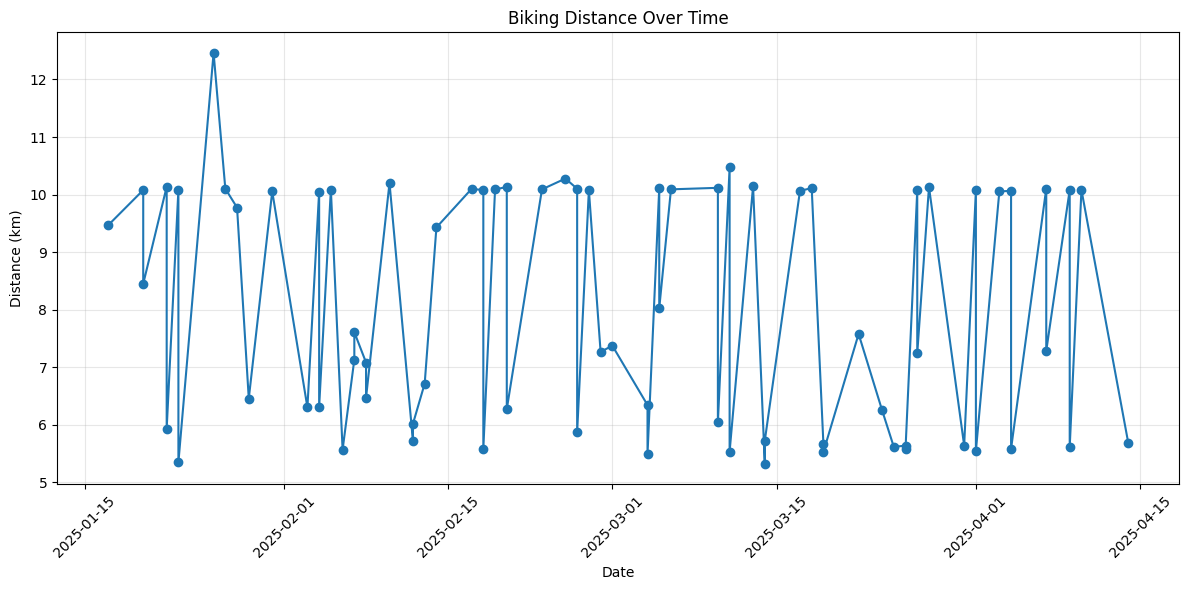

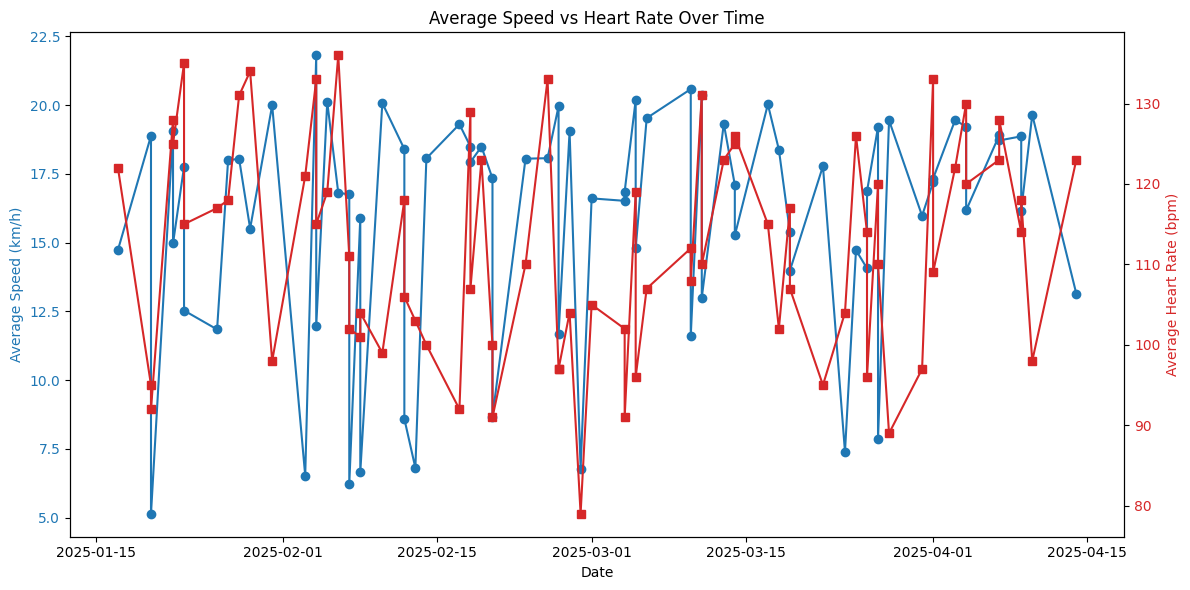

No sleep data to visualize.
Insufficient data for correlation analysis.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Biking data saved to 'biking_data.csv'


In [9]:
import numpy as np
from datetime import datetime, timedelta

# Set date range for analysis
end_date = datetime.now()
start_date = end_date - timedelta(days=90)  # Data for the last 90 days

print(f"Fetching data from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")

# Get biking data
biking_df = get_activities(client, activity_type='cycling', start_date=start_date, end_date=end_date)
print(f"Retrieved {len(biking_df)} biking activities")

# Get sleep data
sleep_df = get_sleep_data(client, start_date=start_date, end_date=end_date)
print(f"Retrieved sleep data for {len(sleep_df)} days")

# Run visualizations
if not biking_df.empty:
    print("\nVisualizing biking data...")
    visualize_biking_data(biking_df)
else:
    print("No biking data to visualize.")

if not sleep_df.empty:
    print("\nVisualizing sleep data...")
    visualize_sleep_data(sleep_df)
else:
    print("No sleep data to visualize.")

# Run correlation analysis
if not biking_df.empty and not sleep_df.empty:
    print("\nAnalyzing correlation between biking and sleep...")
    analyze_biking_sleep_correlation(biking_df, sleep_df)
else:
    print("Insufficient data for correlation analysis.")

# Save data to CSV
if not biking_df.empty:
    biking_df.to_csv('biking_data.csv', index=False)
    files.download('biking_data.csv')
    print("Biking data saved to 'biking_data.csv'")

if not sleep_df.empty:
    sleep_df.to_csv('sleep_data.csv', index=False)
    files.download('sleep_data.csv')
    print("Sleep data saved to 'sleep_data.csv'")